In [2]:
!pip install pytorch-pretrained-bert==0.4.0
!pip install pytorch-pretrained-bert pytorch-nlp
!pip install seqeval==0.0.12

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 3.1 MB/s 
     |████████████████████████████████| 132 kB 64.9 MB/s 
     |████████████████████████████████| 79 kB 8.9 MB/s 
     |████████████████████████████████| 10.2 MB 49.1 MB/s 
     |████████████████████████████████| 140 kB 80.3 MB/s 
     |████████████████████████████████| 127 kB 79.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 277 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7434 sha256=be5e8992bb80f72d857214baa61e0f81ed9f4621a60b5073dd1ed056

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import pandas as pd
import math
import numpy as np
import os
import re
import logging
import json

In [5]:
from google.colab import files
uploaded = files.upload()

Saving Entity Recognition in Resumes.json to Entity Recognition in Resumes.json


In [6]:
data_file_address = "Entity Recognition in Resumes.json"

In [7]:
# Reading data
df = pd.read_json('Entity Recognition in Resumes.json', lines=True)
df.head()

,content,annotation,extras
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12...",NaN
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta...",NaN
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80...",NaN
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20...",NaN


In [8]:
df['extras'].unique()

array([nan])

In [9]:
# Removing New Line characters
for i in range(len(df)):
    df["content"][i] = df["content"][i].replace("\n", " ")
df.head()

<ipython-input-9-c09736c00fa5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["content"][i] = df["content"][i].replace("\n", " ")


,content,annotation,extras
0,Abhishek Jha Application Development Associate...,"[{'label': ['Skills'], 'points': [{'start': 12...",NaN
1,Afreen Jamadar Active member of IIIT Committee...,"[{'label': ['Email Address'], 'points': [{'sta...",NaN
2,"Akhil Yadav Polemaina Hyderabad, Telangana - E...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN
3,Alok Khandai Operational Analyst (SQL DBA) Eng...,"[{'label': ['Skills'], 'points': [{'start': 80...",NaN
4,Ananya Chavan lecturer - oracle tutorials Mum...,"[{'label': ['Degree'], 'points': [{'start': 20...",NaN


In [10]:
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report,accuracy_score,f1_score
import torch.nn.functional as F
import torch
from tqdm import tqdm,trange
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import random
import logging
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [11]:
# JSON formatting functions
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, 'r') as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content'].replace("\n", " ")
            entities = []
            data_annotations = data['annotation']
            if data_annotations is not None:
                for annotation in data_annotations:
                    #only a single point in text annotation.
                    point = annotation['points'][0]
                    labels = annotation['label']
                    # handle both list of labels or a single label.
                    if not isinstance(labels, list):
                        labels = [labels]

                    for label in labels:
                        point_start = point['start']
                        point_end = point['end']
                        point_text = point['text']
                        
                        lstrip_diff = len(point_text) - len(point_text.lstrip())
                        rstrip_diff = len(point_text) - len(point_text.rstrip())
                        if lstrip_diff != 0:
                            point_start = point_start + lstrip_diff
                        if rstrip_diff != 0:
                            point_end = point_end - rstrip_diff
                        entities.append((point_start, point_end + 1 , label))
            training_data.append((text, {"entities" : entities}))
        return training_data
    except Exception as e:
        logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
         """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data       

In [12]:
data = trim_entity_spans(convert_dataturks_to_spacy(data_file_address))
data[5]

["Anvitha Rao Automation developer  - Email me on Indeed: indeed.com/r/Anvitha-Rao/9d6acc68cc30c71c  Seeking a software development internship position for Summer 2018 that utilizes my technical skills, education and passion for solving interesting problems as a software professional.  Willing to relocate: Anywhere  WORK EXPERIENCE  Automation developer  SAP Labs -  Bengaluru, Karnataka -  August 2016 to August 2017  Worked as an automation developer in the development of cloud based Human capital management System and Integration frameworks Dell Boomi and SAP HANA Cloud Platform Integration. ● Development of automation framework using Java Selenium and RestFul API's for payroll projects. ● Collaborating with customers on migrating Payroll projects to SAP HANA Cloud Platform Integration. ● Involved in regression, unity, functionality, performance, sanity and acceptance test driven development process.  Intern  SAP Labs -  Bengaluru, Karnataka -  February 2016 to July 2016  Worked on mi

In [14]:
# Changing data to appropriate format so as to feed it to the model
from tqdm import tqdm_notebook as tqdm
cleanedDF = pd.DataFrame(columns=["setences_cleaned"])
sum1 = 0
for i in tqdm(range(len(data))):
    start = 0
    emptyList = ["Empty"] * len(data[i][0].split())
    numberOfWords = 0
    lenOfString = len(data[i][0])
    strData = data[i][0]
    strDictData = data[i][1]
    lastIndexOfSpace = strData.rfind(' ')
    for i in range(lenOfString):
        if (strData[i]==" " and strData[i+1]!=" "):
            for k,v in strDictData.items():
                for j in range(len(v)):
                    entList = v[len(v)-j-1]
                    if (start>=int(entList[0]) and i<=int(entList[1])):
                        emptyList[numberOfWords] = entList[2]
                        break
                    else:
                        continue
            start = i + 1  
            numberOfWords += 1
        if (i == lastIndexOfSpace):
                 for j in range(len(v)):
                    entList = v[len(v)-j-1]
                    if (lastIndexOfSpace>=int(entList[0]) and lenOfString<=int(entList[1])):
                        emptyList[numberOfWords] = entList[2]
                        numberOfWords += 1
    cleanedDF = cleanedDF.append(pd.Series([emptyList],  index=cleanedDF.columns ), ignore_index=True )
    sum1 = sum1 + numberOfWords

<ipython-input-14-f54cb8fbf585>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(data))):


  0%|          | 0/220 [00:00<?, ?it/s]

In [15]:
cleanedDF.head()

,setences_cleaned
0,"[Name, Name, Designation, Designation, Designa..."
1,"[Name, Name, Empty, Empty, Empty, Empty, Empty..."
2,"[Name, Name, Name, Empty, Empty, Empty, Empty,..."
3,"[Name, Name, Designation, Designation, Designa..."
4,"[Name, Name, Designation, Empty, Companies wor..."


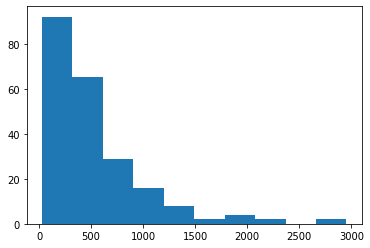

In [17]:
import matplotlib.pyplot as plt
totalNumWords = [len(one_comment.split()) for one_comment in df["content"]]
plt.hist(totalNumWords)
plt.show()

In [18]:
MAX_LEN = 300
bs = 16

In [19]:
device = torch.device("cuda")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0) 

'Tesla T4'

In [21]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
from keras.preprocessing.text import Tokenizer 
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df["content"])

In [23]:
tokenized_texts = tokenizer.texts_to_sequences(df["content"])
# tokenized_texts = [tokenizer.tokenize(sent) for sent in df["content"]]
print(tokenized_texts[0])

[3331, 3332, 37, 52, 302, 517, 150, 72, 62, 59, 8, 11, 11, 13, 17, 3331, 3332, 4387, 2, 4, 23, 7, 88, 193, 105, 603, 59, 3, 890, 4, 814, 120, 20, 1, 58, 7, 120, 843, 1, 2736, 448, 5, 341, 1354, 2079, 190, 4, 198, 4, 154, 72, 23, 16, 37, 52, 302, 517, 320, 111, 4, 91, 163, 534, 76, 8, 1733, 2737, 289, 1891, 39, 1734, 449, 7, 3, 2737, 105, 244, 139, 3333, 97, 8, 481, 1355, 221, 130, 3, 2737, 7, 172, 1354, 6000, 408, 786, 1, 3334, 105, 244, 139, 481, 15, 1355, 41, 3, 128, 63, 143, 234, 5, 54, 241, 1, 145, 143, 535, 143, 159, 6, 145, 1, 78, 3335, 72, 257, 110, 4, 131, 111, 2738, 5, 2739, 6001, 3336, 202, 283, 175, 4, 290, 110, 2381, 6002, 6003, 283, 1263, 4, 290, 175, 20, 73, 67, 56, 24, 33, 83, 67, 56, 24, 33, 83, 12, 67, 56, 24, 33, 83, 12, 44, 67, 56, 24, 33, 81, 67, 56, 24, 33, 100, 54, 45, 20, 32, 34, 11, 13, 17, 3331, 3332, 4387, 47, 48, 14, 49, 14, 43, 35, 5, 2, 267, 329, 73, 73, 81, 2, 39, 1734, 2, 815, 6, 2382, 2, 891, 426, 2, 83, 12, 44, 2, 170, 1086, 2, 192, 44, 66, 8, 188, 71, 

In [24]:
input_ids = pad_sequences(tokenized_texts,
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [25]:
tags_vals = ["UNKNOWN", "Name", "Degree","Skills","College Name","Email Address","Designation","Companies worked at","Empty","Graduation Year","Years of Experience","Location"]
tag2idx = {t: i for i, t in enumerate(tags_vals)}

In [26]:
labels = cleanedDF["setences_cleaned"].tolist()

In [27]:
print(set(labels[61]))

{'Empty', 'Degree', 'Skills', 'Companies worked at', 'UNKNOWN', 'Name', 'Years of Experience', 'College Name', 'Designation'}


In [28]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["Empty"], padding="post",
                     dtype="long", truncating="post")

In [29]:
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

In [30]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [31]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [32]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [33]:
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(tag2idx))


100%|██████████| 407873900/407873900 [01:09<00:00, 5849789.06B/s]


In [34]:
model.cuda();

In [35]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [36]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [37]:
epochs = 5
max_grad_norm = 1.0

for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
          # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
    valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.6982294389834771


Epoch:  20%|██        | 1/5 [00:15<01:01, 15.31s/it]

Validation loss: 0.43115097284317017
Validation Accuracy: 0.9231944444444444
F1-Score: 0.9242331288343558
Train loss: 0.447145198400204


Epoch:  40%|████      | 2/5 [00:27<00:40, 13.58s/it]

Validation loss: 0.4058609902858734
Validation Accuracy: 0.9231944444444444
F1-Score: 0.9242331288343558
Train loss: 0.46564271358343273


Epoch:  60%|██████    | 3/5 [00:40<00:26, 13.14s/it]

Validation loss: 0.40568190813064575
Validation Accuracy: 0.9231944444444444
F1-Score: 0.9242331288343558
Train loss: 0.4351355926348613


Epoch:  80%|████████  | 4/5 [00:53<00:12, 12.97s/it]

Validation loss: 0.3908022344112396
Validation Accuracy: 0.9231944444444444
F1-Score: 0.9242331288343558
Train loss: 0.43051072496634263


Epoch: 100%|██████████| 5/5 [01:05<00:00, 13.19s/it]

Validation loss: 0.3766806870698929
Validation Accuracy: 0.9231944444444444
F1-Score: 0.9242331288343558
